# Elasticity equation - compute CFF

In this tutorial we present how to solve the elasticity equation with [PorePy](https://github.com/pmgbergen/porepy) and then how to post process the tractions to compute the CFF (Coulomb friction failure) coefficient along a fracture. The unknown is the displacement $u$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\lambda$ Lamé constant and $\mu$ the Kirchhoff modulus, we want to solve the following problem: find $u$ such that
$$
\nabla \cdot [ 2 \mu \epsilon(u) + \lambda \nabla \cdot u] = -b
$$
with $\epsilon$ the symmetric gradient and $b$ a body force. The CFF is computed as
$$
    CFF = \tau^\top \sigma n + \mu_f n^\top \sigma n
$$
with $\mu_f$ the fracture friction coefficient. We have the following possibilities
- No slip: $CFF < 0$
- Slipping: $CFF \geq 0$

We will use the Multi-Point Stress Approximation (MPSA) to discretise the problem.

## Exercise 1: footing problem

The footing problem is when a force is impose on the top compressing the body and the bottom is fixed.

For this test case we set $\Omega = [0, 1]^2$, $b = 0$, and the following boundary conditions:
$$ 
u = 0 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot \sigma = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \qquad \nu \cdot \sigma = [0, -1e-3]^\top \text{ on } \partial_{top} \Omega
$$

We have the following relations between the $\lambda$ and $\mu$ as functions of the Young's modulus $E$ and Poisson ratio $\nu$
$$
\lambda = \dfrac{\nu E}{(1+\nu)(1-2\nu)}\qquad \mu = \dfrac{E}{2(1+\nu)}
$$

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid and the fracture/fault now represent an internal constraint so that the grid adapts to it.

In [2]:
N = 10
dim = 2
mesh_size = 1 / N

# Define a fracture
frac_pts = np.array(
    [
        [0.2, 0.9],
        [0.2, 1],
    ]
)
frac = pp.LineFracture(frac_pts)

sd = pg.unit_grid(dim, mesh_size, as_mdg=False, fractures=[frac], constraints=[0])
sd.compute_geometry()

We can also visualize the grid.

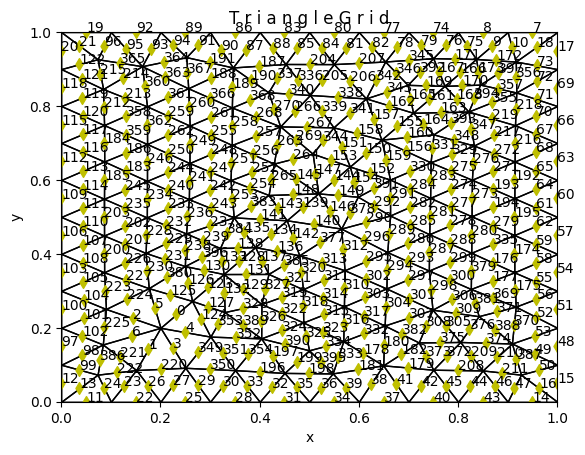

In [3]:
pp.plot_grid(sd, info="f", plot_2d=True, alpha=0)

With the following code we set the data, in particular the Lamé and the Kirchhoff modulus, and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [4]:
key = "elasticity"

E = 1
nu = 0.25
mu_fric = 0.45

# forces imposed at the boundary
fun_top = -1e-2  # -1e-2 (no slip) or -2.5e-2 (some slip) or -3e-2 (slip)
fun_left = 1e-2
fun_right = -1e-2

lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

# Create stiffness matrix
lambda_ = lambda_ * np.ones(sd.num_cells)
mu = mu * np.ones(sd.num_cells) / 2
C = pp.FourthOrderTensor(mu, lambda_)

# Define boundary type
b_faces = sd.get_all_boundary_faces()
num_b_faces = b_faces.size
labels = np.array(["neu"] * num_b_faces)

bottom = np.isclose(sd.face_centers[1, b_faces], 0)
labels[bottom] = "dir"
bound = pp.BoundaryConditionVectorial(sd, b_faces, labels)

bc_values = np.zeros((sd.dim, sd.num_faces))

# force from the top of the domain
top = np.isclose(sd.face_centers[1, :], 1)
bc_values[1, top] = fun_top * sd.face_areas[top]

# compressive force on the left and right
left = np.isclose(sd.face_centers[0, :], 0)
bc_values[0, left] = fun_left * sd.face_areas[left]

right = np.isclose(sd.face_centers[0, :], 1)
bc_values[0, right] = fun_right * sd.face_areas[right]

bc_values = bc_values.ravel("F")

# No source term
source = np.zeros(sd.num_cells * sd.dim)

# collect all data
data = {
    pp.PARAMETERS: {
        key: {
            "fourth_order_tensor": C,
            "bc_values": bc_values,
            "bc": bound,
            "source": source,
        }
    },
    pp.DISCRETIZATION_MATRICES: {key: {}},
}

Once the data are assigned to the grid, we construct the matrices. Once the latter is created, we also construct the right-hand side containing the boundary conditions.

In [5]:
# discretize and solve the system
mpsa = pp.Mpsa(key)
mpsa.discretize(sd, data)

A, b = mpsa.assemble_matrix_rhs(sd, data)
u = sps.linalg.spsolve(A, b)

We first compute the traction for each face of the cell and reshape it so that it has the x-components for all the faces first and then all the y-components (and then all z-components in 3d case).

In [6]:
# post process the traction for each face
mat = data[pp.DISCRETIZATION_MATRICES][key]
mat_stress = mat[mpsa.stress_matrix_key]
mat_bound_stress = mat[mpsa.bound_stress_matrix_key]

# The measure is in Pascals
t = mat_stress @ u + mat_bound_stress @ bc_values

# reshape the traction to be in the order of first all the x-components, then all the
# y-components
t = np.reshape(t, (sd.dim, -1), order="F").ravel()

We restrict the traction to the fracture faces

In [7]:
# compute the faces that are on the fracture
points = sd.face_centers[:2]
dist, _ = pp.distances.points_segments(points, frac_pts[:, 0], frac_pts[:, 1])
faces_on_frac = np.isclose(dist.ravel(), 0)

# extract the x and y components of the tractions on the fracture and make it as a
# vector
t_on_frac = t[np.tile(faces_on_frac, sd.dim)].reshape((sd.dim, -1))
t_on_frac = np.vstack((t_on_frac, np.zeros(t_on_frac.shape[1])))  # 2d only

We compute now the normal and tangential projection matrices, so that given a vector it aligns it accordingly.

In [8]:
# compute the unit normal vector to the fracture
normal = sd.face_normals[:, faces_on_frac]
normal /= np.linalg.norm(normal, axis=0)

# compute the normal and tangential projection matrix to the fracture
normal_proj = np.einsum("ik,jk->ijk", normal, normal)
tangential_proj = np.eye(3)[:, :, np.newaxis] - normal_proj

Let us compute now the normal and tangential parts of the traction and evaluate the CFF.

In [9]:
# compute the normal component of the traction
t_normal_vec = np.einsum("ijk,jk->ik", normal_proj, t_on_frac)
t_normal = np.einsum("ij,ij->j", normal, t_normal_vec)

# compute the tangential component of the traction
t_tangential_vec = np.einsum("ijk,jk->ik", tangential_proj, t_on_frac)
t_tangential = np.linalg.norm(t_tangential_vec, axis=0)

# compute the Coulomb friction factor
cff = t_tangential + mu_fric * t_normal

print(cff)
print("Number of slipping faces:", np.sum(cff >= 0), "over", cff.size)

[-0.00039051 -0.00043585 -0.00039628 -0.00040943 -0.00041716 -0.00041559
 -0.00041972 -0.00042728 -0.00043445 -0.0004389  -0.00043838]
Number of slipping faces: 0 over 11


 Compute now the stress tensor, one `sd.dim` x `sd.dim` tensor per cell.

In [10]:
# vecRT0 = pg.VecRT0(key) # this is for simplices
vecRT0 = pg.VecVRT0(key)  # for general grids using vem
P0 = vecRT0.eval_at_cell_centers(sd)
cell_sigma = P0 @ t

# first we reshape sigma for each dimension and then split agin for each cell, so that we
# have for the 2d case
# [xx, xy, xz]*cells + [yx, yy, yz]*cells -> [[xx, xy, xz]*cells, [yx, yy, yz]*cells]
# [[xx, xy, xz]*cells, [yx, yy, yz]*cells] -> [[xx, xy, xz], [yx, yy, yz]]*cells
cell_sigma = np.array(np.hsplit(cell_sigma.reshape(sd.dim, -1), sd.num_cells))

# we can remove the z component to have it sd.num_cells x sd.dim x sd.dim
cell_sigma = cell_sigma[:, :, : sd.dim]

# we can split the tensor in each component
cell_sigma_xx = cell_sigma[:, 0, 0]
cell_sigma_xy = cell_sigma[:, 0, 1]
cell_sigma_yy = cell_sigma[:, 1, 1]

We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [11]:
# reshape the displacement for the export
u = np.reshape(u, (sd.dim, -1), order="F")
u = np.vstack((u, np.zeros(sd.num_cells)))

save = pp.Exporter(sd, "sol", folder_name="ex1")
save.write_vtu(
    [
        ("cell_u", u),
        ("cell_sigma_xx", cell_sigma_xx),
        ("cell_sigma_xy", cell_sigma_xy),
        ("cell_sigma_yy", cell_sigma_yy),
    ]
)

In [12]:
# Consistency check
assert np.isclose(cff.sum(), -0.004623556275109453)